In [1]:
import cv2
import mediapipe as mp
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if landing with a sliding technique is performed
def is_sliding_landing(ankle, knee, hip, pelvis):
    """
    Determines if the landing is performed using a sliding technique.
    Conditions:
    - The ankle should be ahead of the knee (forward sliding motion).
    - The hip should be behind the knee to indicate a backward lean.
    - The pelvis should be stable above the hip for proper balance.
    """
    ankle_x, ankle_y = ankle
    knee_x, knee_y = knee
    hip_x, hip_y = hip
    pelvis_x, pelvis_y = pelvis

    ankle_ahead_knee = ankle_x > knee_x  # Ankle should be ahead of knee
    hip_behind_knee = hip_x < knee_x  # Hip should be behind the knee
    pelvis_stable = abs(pelvis_x - hip_x) < 0.05  # Pelvis stability over the hip

    return ankle_ahead_knee and hip_behind_knee and pelvis_stable

# Paths for the videos and keypoints storage
stage_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/distance_jump/stages/stage5/videos"
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/distance_jump/stages/stage5/keypoints"

# Ensure keypoints folder exists
os.makedirs(keypoints_folder, exist_ok=True)

for file in os.listdir(stage_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(stage_path, file)
        cap = cv2.VideoCapture(video_file_path)

        keypoints_data = []  # Store keypoints for this video

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB for MediaPipe processing
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = pose.process(frame_rgb)

            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark

                # Extract relevant keypoints (ankles, knees, hips, pelvis)
                left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                              landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y]
                right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x,
                               landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y]

                left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y]
                right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x,
                              landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y]

                left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                            landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
                right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x,
                             landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]

                left_pelvis = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                               landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]  # Using hip for pelvis approximation
                right_pelvis = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x,
                                landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]  # Using hip for pelvis approximation

                # Determine sliding technique for left and right side
                left_sliding = is_sliding_landing(left_ankle, left_knee, left_hip, left_pelvis)
                right_sliding = is_sliding_landing(right_ankle, right_knee, right_hip, right_pelvis)

                # Store data for this frame
                keypoints_data.append({
                    "frame": int(cap.get(cv2.CAP_PROP_POS_FRAMES)),
                    "left_sliding": left_sliding,
                    "right_sliding": right_sliding,
                    "left_ankle": left_ankle,
                    "right_ankle": right_ankle,
                    "left_knee": left_knee,
                    "right_knee": right_knee,
                    "left_hip": left_hip,
                    "right_hip": right_hip,
                    "left_pelvis": left_pelvis,
                    "right_pelvis": right_pelvis
                })

        cap.release()

        # Save keypoints to the keypoints folder
        json_filename = os.path.splitext(file)[0] + "_keypoints.json"
        json_path = os.path.join(keypoints_folder, json_filename)
        with open(json_path, "w") as json_file:
            json.dump(keypoints_data, json_file, indent=4)

print("Landing with sliding technique analysis complete! JSON files saved in 'keypoints' folder.")

I0000 00:00:1737741811.570680 13286131 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1737741811.629231 13286350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737741811.637411 13286355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737741811.649167 13286361 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Landing with sliding technique analysis complete! JSON files saved in 'keypoints' folder.


In [3]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Path to the keypoints folder for sliding landing analysis
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/distance_jump/stages/stage5/keypoints"

# Lists to store sequences and labels
sequences = []
labels = []

# Process keypoint JSON files
for file in os.listdir(keypoints_folder):
    if file.endswith("_keypoints.json"):
        file_path = os.path.join(keypoints_folder, file)
        
        with open(file_path, "r") as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                print(f"Error loading JSON from {file}")
                continue

        # Ensure data is in expected format
        if isinstance(data, list):
            sliding_data = [
                [
                    int(frame.get("left_sliding", 0)),  # Left foot sliding status
                    int(frame.get("right_sliding", 0))  # Right foot sliding status
                ]
                for frame in data if isinstance(frame, dict)
            ]
            sequences.append(sliding_data)
        else:
            print(f"Unexpected format in {file}, skipping.")
            continue

        # Extract label from filename (assumes label is the first part of filename)
        try:
            label = float(file.split("_")[0])  # Modify if filename structure differs
            labels.append(label)
        except ValueError:
            print(f"Warning: Unable to extract label from {file}")
            continue

# Pad sequences to the same length
if sequences:
    max_len = max(len(seq) for seq in sequences)
    sequences = pad_sequences(sequences, maxlen=max_len, padding='post', dtype='float32')
    labels = np.array(labels)

    print(f"Loaded {len(sequences)} sequences with labels.")
else:
    print("No sequences found in the keypoints folder.")

Loaded 14 sequences with labels.


In [4]:
def augment_data(sequence):
    augmented_sequences = []

    # Original
    augmented_sequences.append(sequence)

    # Mirrored (flip angles horizontally)
    mirrored = -sequence
    augmented_sequences.append(mirrored)

    # Rotation (add a small angle offset)
    rotated = sequence + np.random.uniform(-10, 10, size=sequence.shape)
    augmented_sequences.append(rotated)

    # Noise (add random Gaussian noise)
    noisy = sequence + np.random.normal(0, 0.05, size=sequence.shape)
    augmented_sequences.append(noisy)

    # Scaled (adjust by a small percentage)
    scaled = sequence * np.random.uniform(0.9, 1.1)
    augmented_sequences.append(scaled)

    return augmented_sequences

augmented_sequences = []
augmented_labels = []

for seq, label in zip(sequences, labels):
    augmented = augment_data(seq)
    augmented_sequences.extend(augmented)
    augmented_labels.extend([label] * len(augmented))

augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

print(f"Augmented dataset size: {len(augmented_sequences)}")

Augmented dataset size: 70


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    augmented_sequences, augmented_labels, test_size=4/17, random_state=42
)

# Ensure correct shape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 2))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 2))

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 53, Validation samples: 17


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define enhanced LSTM model
model = Sequential([
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 2))),
    Dropout(0.5),
    Bidirectional(LSTM(32, activation='tanh', return_sequences=False)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output: Regression score
])

# Compile the model with a reduced learning rate for better convergence
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

print(model.summary())


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,  # You can adjust based on convergence
    batch_size=8,  # Smaller batch size for augmented data
    verbose=1
)

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.4139 - mae: 0.4705 - val_loss: 0.3845 - val_mae: 0.5076
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3043 - mae: 0.4275 - val_loss: 0.3487 - val_mae: 0.5378
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2625 - mae: 0.4611 - val_loss: 0.3524 - val_mae: 0.5672
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2859 - mae: 0.5061 - val_loss: 0.3756 - val_mae: 0.5858
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1946 - mae: 0.4166 - val_loss: 0.3908 - val_mae: 0.5887
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2273 - mae: 0.4525 - val_loss: 0.3945 - val_mae: 0.5798
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1953 - mae: 0.4057 - val_loss: 0.4054 - val_mae: 0.5881
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1989 - mae: 0.4088 - val_loss: 0.4164 - val_mae: 0.5972
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.202

In [8]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.2291, Validation MAE: 0.2804


In [9]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Print predictions vs. actual
for i, pred in enumerate(predictions):
    print(f"Predicted: {pred[0]:.2f}, Actual: {y_val[i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Predicted: 0.99, Actual: 0.00
Predicted: -0.01, Actual: 0.00
Predicted: -0.01, Actual: 0.00
Predicted: -0.02, Actual: 0.00
Predicted: 0.94, Actual: 1.00
Predicted: 0.93, Actual: 1.00
Predicted: -0.02, Actual: 0.00
Predicted: 0.97, Actual: 1.00
Predicted: -0.01, Actual: 0.00
Predicted: 0.89, Actual: 0.00
Predicted: 0.03, Actual: 1.00
Predicted: 0.93, Actual: 1.00
Predicted: 0.96, Actual: 0.00
Predicted: 0.94, Actual: 1.00
Predicted: 0.49, Actual: 0.00
Predicted: 0.96, Actual: 1.00
Predicted: 0.93, Actual: 1.00


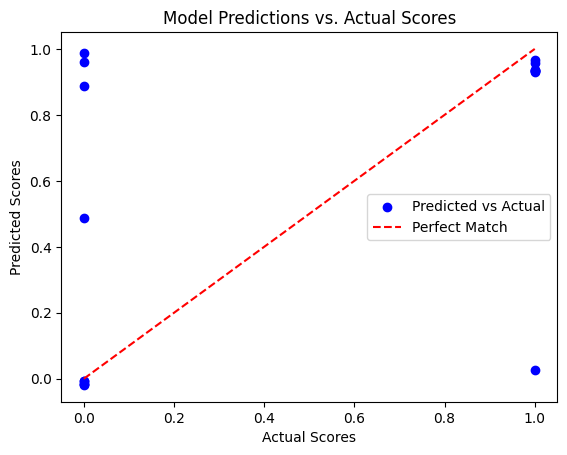

In [10]:
# Scatter plot of predictions vs. actual
import matplotlib.pyplot as plt

plt.scatter(y_val, predictions, c='blue', label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')  # Reference line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Model Predictions vs. Actual Scores')
plt.legend()
plt.show()

In [11]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if landing is performed with a sliding technique
def is_landing_with_sliding(foot, knee, hip, shoulder):
    """
    Determines if the landing is performed with a sliding technique by analyzing 
    the alignment and movement of foot, knee, hip, and shoulder.
    Conditions:
    - Knee should be slightly ahead of the foot.
    - Hip should remain behind the knee indicating a backward lean.
    - Foot should slide forward relative to knee.
    """
    foot_x, foot_y = foot
    knee_x, knee_y = knee
    hip_x, hip_y = hip
    shoulder_x, shoulder_y = shoulder

    knee_ahead = knee_x > foot_x  # Knee slightly ahead of the foot
    hip_behind_knee = hip_x < knee_x  # Hip remains behind knee
    foot_sliding_forward = foot_x > knee_x  # Foot moves forward

    return knee_ahead and hip_behind_knee and foot_sliding_forward

# Path for the new test video
new_video_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/distance_jump/stages/stage5/test_videos/1_user9.mp4"

# Extract keypoints for the new video
new_keypoints = []
cap = cv2.VideoCapture(new_video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark

        # Extract keypoints for left and right side
        left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y]
        right_foot = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y]

        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y]
        right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y]

        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                    landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
        right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x,
                     landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]

        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x,
                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]

        # Check sliding landing status for left and right side
        left_landing_sliding = is_landing_with_sliding(left_foot, left_knee, left_hip, left_shoulder)
        right_landing_sliding = is_landing_with_sliding(right_foot, right_knee, right_hip, right_shoulder)

        # Store binary values (0 or 1) for both sides
        new_keypoints.append([int(left_landing_sliding), int(right_landing_sliding)])

cap.release()

# Get max_seq_length from model input shape dynamically
max_seq_length = model.input_shape[1]  # Dynamically extract sequence length from model

# Pad the sequence to match the expected input shape
new_keypoints_padded = pad_sequences([new_keypoints], maxlen=max_seq_length, padding='post', dtype='float32')

# Reshape the data to match the model's input (samples, timesteps, features)
new_keypoints_padded = new_keypoints_padded.reshape((1, max_seq_length, 2))

print(f"Final input shape for prediction: {new_keypoints_padded.shape}")

# Predict score for the new video
predicted_score = model.predict(new_keypoints_padded)
print(f"Predicted Score: {predicted_score[0][0]:.2f}")

I0000 00:00:1737742168.710694 13286131 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737742168.766706 13358615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737742168.775658 13358615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Final input shape for prediction: (1, 77, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Predicted Score: 0.73


In [12]:
print(model.input_shape)


(None, 77, 2)


In [13]:
print(X_train.shape[1])

77


In [14]:
def classify_score(prediction):
    """Classify the prediction into 0, 0.5, or 1 based on thresholds."""
    if prediction >= 0.70:
        return 1.0
    elif prediction >= 0.4:
        return 0.5
    else:
        return 0.0

In [15]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Apply classification logic
classified_predictions = [classify_score(pred[0]) for pred in predictions]

# Print classified predictions vs actual scores
for i, (pred, actual) in enumerate(zip(classified_predictions, y_val)):
    print(f"Classified: {pred}, Actual: {actual}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Classified: 1.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 0.0
Classified: 0.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 0.5, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0


In [16]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    """Weighted Mean Squared Error to prioritize true negatives."""
    weights = K.switch(y_true < 0.70, 2.0, 1.0)  # Weight true negatives higher
    return K.mean(weights * K.square(y_true - y_pred))

In [17]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_mse, metrics=['mae'])

In [18]:
# Predict and classify scores
classified_predictions = [classify_score(pred[0]) for pred in model.predict(X_val)]

# Evaluate accuracy of classification
correct = sum(1 for pred, actual in zip(classified_predictions, y_val) if pred == actual)
accuracy = correct / len(y_val)

print(f"Classification Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Classification Accuracy: 0.71


In [19]:
model.save("/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/distance_jump/stages/stage5/models/distance_stage5.keras")